In [54]:
import pandas as pd
import numpy as np
import IPython
import graphviz
import re
from IPython.display import display
from sklearn.tree import export_graphviz

%matplotlib inline

In [3]:
with open('./imports-85.names') as f:
    names = f.read()

## Practice Final Problem-2

1. Import the dataset as a pandas dataframe.
2. Prepare this dataset for running Random Forest. What are the steps you need to do?
3. How would you find the best hyperparameters. (Hint: consider random search)
4. Report training and development accuracy.
5. Plot variable importance. Would you remove any variables from the model?



### Part 1: Read In the data and assign the column names

In [4]:
headings = ['symboling','normalized_losses','make','fuel_type','aspiration','num_of_doors','body_style','drive_wheels','engine_location','wheel_base','length','width','height','curb_weight','engine_type','num_of_cylinders','engine_size','fuel_system','bore','stroke','compression_ratio','horsepower','peak_rpm','city_mpg','highway_mpg','price']
df = pd.read_csv('./imports-85.data', names=headings)

In [5]:
from sklearn.ensemble import RandomForestRegressor

### Part 2: Prep the data for random forest

In [6]:
df.shape

(205, 26)

In [7]:
df[df=='?']=np.nan

### Part 2: Drop the rows with no price

In [8]:
df =df[df['price'].isnull()==False]
df =df[df['stroke'].isnull()==False]
df =df[df['peak_rpm'].isnull()==False]
df =df[df['num_of_doors'].isnull()==False]

### Part 2: Double Check for Nulls

In [9]:
df.isna().sum().sort_values()

symboling             0
city_mpg              0
peak_rpm              0
horsepower            0
compression_ratio     0
stroke                0
bore                  0
fuel_system           0
engine_size           0
num_of_cylinders      0
engine_type           0
curb_weight           0
height                0
width                 0
length                0
wheel_base            0
engine_location       0
drive_wheels          0
body_style            0
num_of_doors          0
aspiration            0
fuel_type             0
make                  0
highway_mpg           0
price                 0
normalized_losses    34
dtype: int64

### Part 2: Calculate the normalized mean

In [10]:
df['normalized_losses'] = df['normalized_losses'].astype(float)
mean_normalized_losses = df['normalized_losses'].mean(skipna=True)
mean_normalized_losses

121.13207547169812

### Part 2: Only fill the sections that are missing

In [11]:
df.loc[df['normalized_losses'].isna(),'normalized_losses'] = mean_normalized_losses

### Part 2: Split into X and y variables for the model

In [12]:
y = df['price'].values
feat_cols = [x for x in df.columns if 'price' != x]
X = df[feat_cols].copy()

In [13]:
X.head(1).transpose()

,0
symboling,3
normalized_losses,121.132
make,alfa-romero
fuel_type,gas
aspiration,std
num_of_doors,two
body_style,convertible
drive_wheels,rwd
engine_location,front
wheel_base,88.6


### Part 2: Setup the categorical columns

In [14]:
cat_cols = ['make','body_style','fuel_type','aspiration','num_of_doors','drive_wheels','engine_location','engine_type','num_of_cylinders','fuel_system']

### Part 2:  Setup the continous Columns

In [15]:
cont_cols = [x for x in df.columns if x not in cat_cols]

#### Do the loop for the categorical columns

In [16]:
for col in cat_cols:
    X[col] = X[col].astype('category')

#### setup the numerical matrix (1 hot encode all the categories)

In [17]:
X_matrix = pd.get_dummies(X)

In [18]:
X_matrix.head()

,symboling,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,compression_ratio,city_mpg,...,peak_rpm_5200,peak_rpm_5250,peak_rpm_5300,peak_rpm_5400,peak_rpm_5500,peak_rpm_5600,peak_rpm_5800,peak_rpm_5900,peak_rpm_6000,peak_rpm_6600
0,3,121.132075,88.6,168.8,64.1,48.8,2548,130,9.0,21,...,0,0,0,0,0,0,0,0,0,0
1,3,121.132075,88.6,168.8,64.1,48.8,2548,130,9.0,21,...,0,0,0,0,0,0,0,0,0,0
2,1,121.132075,94.5,171.2,65.5,52.4,2823,152,9.0,19,...,0,0,0,0,0,0,0,0,0,0
3,2,164.000000,99.8,176.6,66.2,54.3,2337,109,10.0,24,...,0,0,0,0,1,0,0,0,0,0
4,2,164.000000,99.4,176.6,66.4,54.3,2824,136,8.0,18,...,0,0,0,0,1,0,0,0,0,0


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_matrix,y, test_size=0.2)

#### Fit our first model!

In [20]:
rfr = RandomForestRegressor(n_estimators=20,n_jobs = -1)

In [21]:
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Part 2: Score our first model

In [23]:
print(rfr.score(X_train,y_train))

0.984667647747


In [24]:
print(rfr.score(X_test,y_test))

0.923464702591


### Part 3: Find optimal parameters of random Forest

In [39]:
from sklearn.model_selection import RandomizedSearchCV
search_params = {
    'n_estimators':[5,10,20,50,100],
    'min_samples_leaf': [2,5,7,10],
    'max_depth': [3,5,7,None],
}
rfr = RandomForestRegressor()
rscv = RandomizedSearchCV(cv=5, estimator=rfr, param_distributions=search_params)
rscv.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [5, 10, 20, 50, 100], 'min_samples_leaf': [2, 5, 7, 10], 'max_depth': [3, 5, 7, None]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

#### Find our best parameters from teh random search

In [40]:
rscv.best_params_

{'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 50}

### Part 4: Report Training and Test Accuracy of our best model

In [44]:
rfr_best = RandomForestRegressor(min_samples_leaf=2, n_estimators=50, n_jobs=-1)
rfr_best.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [45]:
rfr_best.score(X_train, y_train)

0.97068873517299736

In [46]:
rfr_best.score(X_test, y_test)

0.92452869021901385

### Part 5: Plot Feature Importance

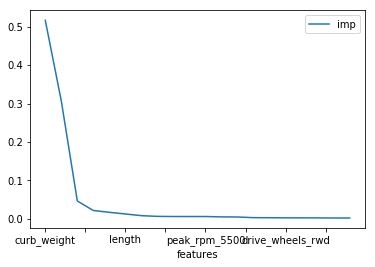

In [57]:
features = X_train.columns
feat_imp = rfr_best.feature_importances_
feat_imp_df = pd.DataFrame({'features': features, 'imp':feat_imp})
feat_imp_df.sort_values(by='imp', ascending = False, inplace=True)
feat_imp_df.head(20).plot(x='features', y='imp')
